In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 48.7 MB/s eta 0:00:00


In [1]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import folium
from datetime import date,timedelta
import requests
from io import BytesIO
from PIL import Image

**Code for Authentication**

In [2]:
ee.Authenticate()
ee.Initialize(project="trial-01-465812")

# Image visualization

In [ ]:
vis_min, vis_max = -0.5,0.5
palette = ['blue','white','red']
vis_img = first.visualize(min=vis_min,max=vis_max,palette=palette)
url = vis_img.getThumbURL({
    'region' : ROI.getInfo()['coordinates'],
    'dimensions':1024
})

resp = requests.get(url)
png = Image.open(BytesIO(resp.content)).convert("RGB")
arr_rgb = np.array(png)


plt.figure(figsize=(8, 6))
plt.imshow(arr_rgb)
plt.axis('off')
plt.title("OMEGA500 (visualized)")
plt.show()

In [3]:

# ------------------------
# CONFIGURATION
# ------------------------
start_year = 2009
end_year = 2009
region = ee.Geometry.BBox(85, 5, 100, 25)  # Example: Bay of Bengal
bands_to_get = ['sst', 'U10M', 'V10M', 'OMEGA500', 'PS', 'QV2M']
new_band_names = ['SST', 'U10M', 'V10M', 'Omega500', 'Pressure', 'Humidity']

def get_daily_image(date_str):
    start = ee.Date(date_str)
    end = start.advance(1, 'day')

    sst = ee.ImageCollection("NOAA/CDR/OISST/V2_1") \
        .filterDate(start, end) \
        .select('sst') \
        .mean() \
        .toFloat()

    u10m = ee.ImageCollection("NASA/GSFC/MERRA/slv/2") \
        .filterDate(start, end) \
        .select('U10M') \
        .mean() \
        .toFloat()

    v10m = ee.ImageCollection("NASA/GSFC/MERRA/slv/2") \
        .filterDate(start, end) \
        .select('V10M') \
        .mean() \
        .toFloat()

    omega500 = ee.ImageCollection("NASA/GSFC/MERRA/slv/2") \
        .filterDate(start, end) \
        .select('OMEGA500') \
        .mean() \
        .toFloat()

    ps = ee.ImageCollection("NASA/GSFC/MERRA/slv/2") \
        .filterDate(start, end) \
        .select('PS') \
        .mean() \
        .toFloat()

    qv2m = ee.ImageCollection("NASA/GSFC/MERRA/slv/2") \
        .filterDate(start, end) \
        .select('QV2M') \
        .mean() \
        .toFloat()

    merged = sst.addBands(u10m).addBands(v10m) \
                .addBands(omega500) \
                .addBands(ps) \
                .addBands(qv2m) \
                .rename(new_band_names) \
                .clip(region)

    return merged


def export_year(year):
    """Export all daily images for one year as TFRecord."""
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)

    dates = ee.List.sequence(0, end_date.difference(start_date, 'day')).map(
        lambda d: start_date.advance(d, 'day').format('YYYY-MM-dd')
    )

    def make_image(date_str):
        return get_daily_image(date_str)

    # Create an ImageCollection of daily merged images
    collection = ee.ImageCollection.fromImages(dates.map(make_image))

    # Export as TFRecord for deep learning
    task = ee.batch.Export.image.toDrive(
        image=collection.toBands(),  # Flatten to single image with multiple bands per day
        description=f'CycloneData_{year}',
        folder='Cyclone_Data',
        fileNamePrefix=f'cyclone_{year}',
        region=region,
        scale=10000,  # adjust for resolution
        maxPixels=1e13
    )
    task.start()
    print(f"Export started for {year}.")

# Run year by year
for y in range(start_year, end_year + 1):
    export_year(y)


Export started for 2009.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


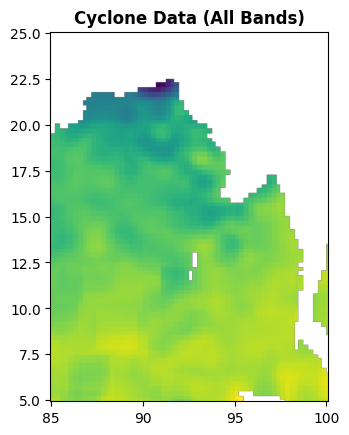

In [ ]:
import rasterio
from rasterio.plot import show

with rasterio.open("/content/drive/MyDrive/Cyclone_Data/cyclone_2010.tif") as src:
    show(src, title="Cyclone Data (All Bands)")

2010-03-15 -> Bands [439, 440, 441, 442, 443, 444]


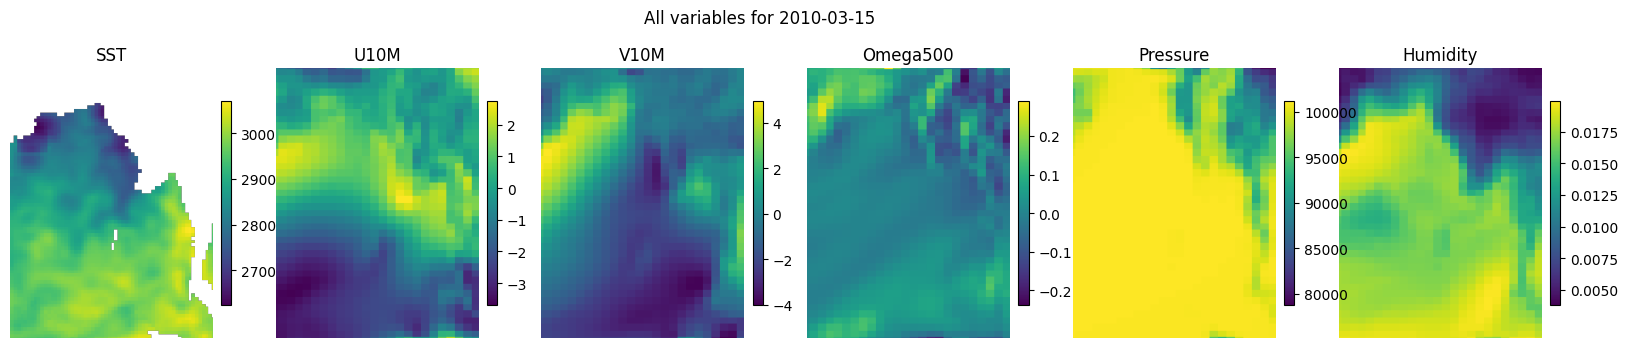

In [ ]:
import rasterio
import matplotlib.pyplot as plt
from datetime import datetime

# ------------------
# CONFIG
# ------------------
tif_file = "/content/drive/MyDrive/Cyclone_Data/cyclone_2010.tif"
start_date = datetime(2010, 1, 1)
variables = ["SST", "U10M", "V10M", "Omega500", "Pressure", "Humidity"]

target_date = datetime(2010, 3, 15)  # date you want to see

# ------------------
# Logic
# ------------------
bands_per_day = len(variables)
day_offset = (target_date - start_date).days
if day_offset < 0:
    raise ValueError("Date is before export period!")

# Band indices for the whole day
band_indices = [day_offset * bands_per_day + i + 1 for i in range(bands_per_day)]
print(f"{target_date.date()} -> Bands {band_indices}")

# Read and plot all variables
with rasterio.open(tif_file) as src:
    fig, axes = plt.subplots(1, bands_per_day, figsize=(20, 4))
    for idx, band_num in enumerate(band_indices):
        data = src.read(band_num)
        ax = axes[idx]
        im = ax.imshow(data, cmap='viridis')
        ax.set_title(variables[idx])
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f"All variables for {target_date.date()}")
plt.show()
